# Model training and selection

In [1]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import time

import data_reader
import dataset

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
MODE = "w"
EXP_NAME = "ejemplo"

DATA_SET_NAME = f"data_set_x20_100%_split"
PATCH_SIZE = 512

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    net = torchvision.models.resnet18(pretrained=True).to(device)
        
    """
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers !!!!
    """

    net.fc = nn.Sequential(
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

    net.fc.apply(init_weights) # Xavier init

    print(f"Loading {MODEL_NAME}")

    # net.fc = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    print("Number of free parameters: ", sum(p.numel() for p in net.fc.parameters()))

    #Hyperparameters:
    learning_rate = 0.0001 # LR
    loss_function = nn.BCELoss()
    # Loss # [1,0] es positivo y [0,1] negativo
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 1 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i].detach().clone()/255)
    
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    conf_m = confusion_matrix( [torch.argmax(i) for i in y.cpu()],[torch.argmax(i) for i in outputs.cpu()], labels=(0, 1))
    f1 = conf_m[0][0]/(conf_m[0][0]+0.5*(conf_m[1][0]+conf_m[0][1]))
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss, f1, conf_m

In [6]:
def validate(X, y, size=32):
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  '''
  if size > 0.7*len(val_set):
    ramdom_start = 0
  else:
    ramdom_start = np.random.randint(len(val_set)-size)

  # X, y = val_X[ramdom_start:ramdom_start+size].to(device), val_y[ramdom_start:ramdom_start+size].to(device)
  '''

  val_acc, val_loss, val_f1, val_conf_m = fwd_pass(X, y, train=False)

  return val_acc, val_loss, val_f1, val_conf_m # accuracy y loss en validation set

In [7]:
def test():
  X, y = test_X.to(device), test_y.to(device)
  test_acc, test_loss, test_f1, test_conf_m = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y)
  del X, y

  return test_acc, test_loss, test_f1, test_conf_m

In [8]:
%%time

def train():

  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME

  print(MODEL_NAME)
  EPOCHS = 10
  
  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1 = 0, 0, 0
      val_acc, val_loss, val_f1 = 0, 0, 0
      conf_m, val_conf_m = np.array([[0,0],[0,0]]), np.array([[0,0],[0,0]])
      i = 0

      print("\nEPOCH: ", epoch+1)

      for batch_X, batch_y in tqdm(iter(train_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, f1_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux*(len(batch_X)/len(train_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/len(train_set))
        f1 += f1_aux*(len(batch_X)/len(train_set))
        conf_m += conf_m_aux

        i += 1
    
        if i%100 == 0:
          print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)
        
      #del train_set
      #torch.cuda.empty_cache()

      i = 0
      
      for batch_X, batch_y in tqdm(iter(val_dataloader)):
        
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        acc_aux, loss_aux, f1_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=False)
      
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc trough batches
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux

        del batch_X, batch_y
        torch.cuda.empty_cache()

        print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)

      #del val_set
      #torch.cuda.empty_cache()

      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")
      print("Val CONF: ", val_f1," Train f1: ", f1, "\n")

      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")


CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
# Choosing only the images from the according splits (10CV)

BATCH_SIZE = 16

for SPLIT in range(1):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS =list(range(2))
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [])
    val_set = dataset.PatchDataset([], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)

    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    init()

    train()


Loading training split: 1
Read lmdb
Patches for training: 13812

Loading validation split: 0
Read lmdb
Loading ejemplo0
Number of free parameters:  65922
ejemplo0

EPOCH:  1


  0%|          | 0/864 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793
Memory allocated in GPU:  0.2161707878112793


  0%|          | 0/1058 [00:00<?, ?it/s]

Memory allocated in GPU:  1.895897388458252
Memory allocated in GPU:  3.6224989891052246
Memory allocated in GPU:  5.349100589752197
Memory allocated in GPU:  7.07570219039917
Memory allocated in GPU:  8.802303791046143


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 12.00 GiB total capacity; 9.41 GiB already allocated; 0 bytes free; 9.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import torch
a = torch.zeros(300000000, dtype=torch.int8, device='cuda:0') 
b = torch.zeros(300000000, dtype=torch.int8, device='cuda:0') # Check GPU memory using nvidia-smi
c = torch.zeros(300000000, dtype=torch.int8, device='cuda:0') # Check GPU memory using nvidia-smi

print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)
del a 
torch.cuda.empty_cache()

print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)


Memory allocated in GPU:  0.838191032409668
Memory allocated in GPU:  0.5587940216064453


In [ ]:
def learning_curve(NAME):
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{NAME}.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "VAL_ACC", "VAL_LOSS"]

  fig, axs = plt.subplots(2, figsize=(5,7))
  #ax = plt.gca() # GET CURRENT AXIS

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{NAME}.pdf")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_13176\1170274862.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_ejemplo1.log'

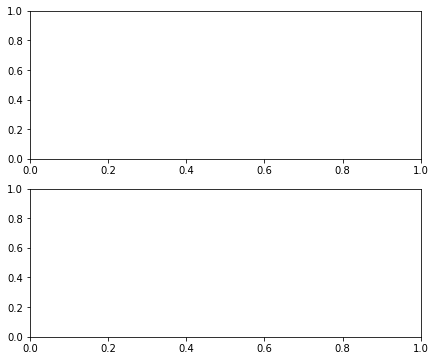

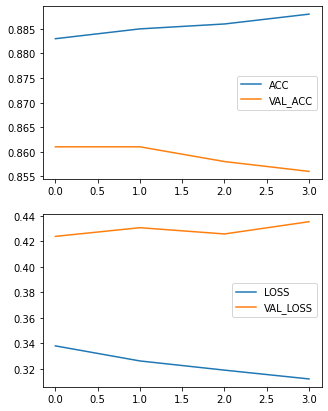

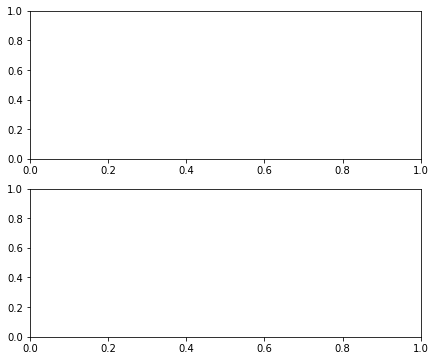

In [ ]:
for SPLIT in range(2):
    NAME = MODEL_NAME[:-1]+f"{SPLIT}"
    learning_curve(NAME)